In [1]:
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import imageio
import cv2
from tqdm import tqdm
from skimage.measure import shannon_entropy
import pickle
import concurrent.futures

# Part A

In [3]:


#read frames
def read_frames_imageio(video_path):
    print("Reading frames ...")
    vid = imageio.get_reader(video_path, 'ffmpeg')
    frames = [frame for frame in vid]
    return frames

#calculate image entropy
def calculate_image_entropy(image):
    entropy=shannon_entropy(image)
    return entropy

#Looking for threshold manually in the first n images
def plot_entropies(frames, n):
    print("Plotting entropies ...")
    example_entropies=[]
    for frame in frames[:n]:
        #crop unnecessary parts
        frame=frame[:,22:110,:]
        #convert to grayscale
        gray_image = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        #calculate entropies
        entropy=calculate_image_entropy(frame)
        example_entropies.append(entropy)
    plt.plot(example_entropies)
    plt.xlabel("Index of images")
    plt.ylabel("Image entropies")
    plt.show()

def process_frame(frame, threshold=4.4):
    # Process a single frame
    frame = frame[:, 22:110, :]  # Crop
    gray_image = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    entropy = calculate_image_entropy(gray_image)  # Calculate entropy
    if entropy > threshold:
        return gray_image
    return None

def preprocess_frames(frames, threshold=4.4):
     #Multithreading
     
    processed_images = []
    try:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(process_frame, frame, threshold): frame for frame in frames}

            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Preprocessing frames"):
                result = future.result()
                if result is not None:
                    processed_images.append(result)

    except Exception as e:
        print(f"An error occurred: {e}")

    return processed_images


def create_video(image_list, output_path, fps=30, size=None):
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if size is None:
        size = (image_list[0].shape[1], image_list[0].shape[0])
    out = cv2.VideoWriter(output_path, fourcc, fps, size)

    for img in tqdm(image_list, desc="Creating video ..."):
        frame = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        out.write(frame)

    out.release()
    cv2.destroyAllWindows()

Reading frames ...
Total frames: 356953
Plotting entropies ...


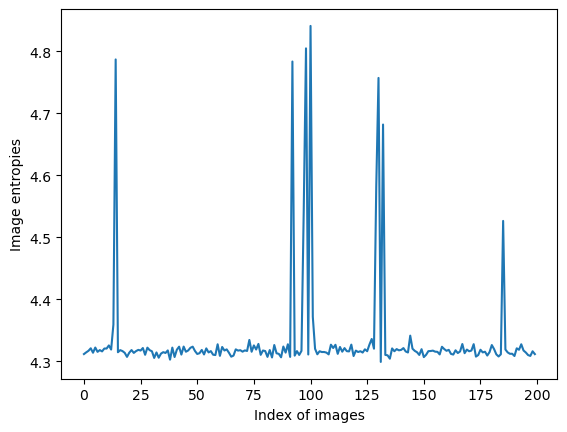

Preprocessing frames: 100%|███████████████████████████████████████████████████| 356953/356953 [11:34<00:00, 513.70it/s]


Filtered frames: 23813


Creating video ...: 100%|██████████████████████████████████████████████████████| 23813/23813 [00:12<00:00, 1884.64it/s]


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [4]:
video_path = 'CellA_noDoxycycline.avi'
#read_frames
frames = read_frames_imageio(video_path)
print(f"Total frames: {len(frames)}")

#plot entropies for first 200 images
plot_entropies(frames, 200)

#Filter and preprocess frames to remove images with entropies below threshold
processed=preprocess_frames(frames, threshold=4.4)
print(f"Filtered frames: {len(processed)}")

#For quicker access, dump the data into pickle and read from it
with open('filtered.pkl', 'wb') as f:
    pickle.dump(processed, f)

with open('filtered.pkl', 'rb') as f:
    filtered_list = pickle.load(f)

#create a video out of filtered images
create_video(filtered_list, 'Part_A_output.avi', fps=1)

